# Salary Predictions Based on Job Descriptions

# Part 1 - DEFINE

### ---- 1 Define the problem ----

A dataset of job posting and thier salaries are given, after the initial data prep, cleaning and EDA-(inference on the data with numerical/visual representation), we create a model to predict the salaries based on the given data. 

In [294]:
#analysis libraries
import pandas as pd
import numpy as np
import scipy.stats as stats

#data visulization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(color_codes=True)

#for feature selection
from sklearn.linear_model import Lasso

from sklearn.preprocessing import MinMaxScaler,LabelEncoder


from sklearn.metrics import mean_squared_error, accuracy_score, r2_score
from sklearn.model_selection import cross_val_score,train_test_split
 
        

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression


import warnings
warnings.filterwarnings('ignore')



#Author Information
__author__ = "Naveen Shivappa Thenehalli"
__email__ = "naveensthenehalli93@gmail.com"

## Part 2 - DISCOVER

### ---- 2 Load the data ----

In [295]:
#Reading the csv format datasets into pandas dataframe

#train_data
train_f = pd.read_csv("train_features.csv")
train_s = pd.read_csv("train_salaries.csv")

#test_data
test_f = pd.read_csv("test_features.csv")

#Print first 3 rows of each dataset to have a look at the data

#train_data
print("Train Features:")
print(train_f.head(3))
print("\n Train Salaries:")
print(train_s.head(3))

#test_data
print("\n Test Dataset:")
print(test_f.head(3))

Train Features:
              jobId companyId         jobType       degree    major industry  \
0  JOB1362684407687    COMP37             CFO      MASTERS     MATH   HEALTH   
1  JOB1362684407688    COMP19             CEO  HIGH_SCHOOL     NONE      WEB   
2  JOB1362684407689    COMP52  VICE_PRESIDENT     DOCTORAL  PHYSICS   HEALTH   

   yearsExperience  milesFromMetropolis  
0               10                   83  
1                3                   73  
2               10                   38  

 Train Salaries:
              jobId  salary
0  JOB1362684407687     130
1  JOB1362684407688     101
2  JOB1362684407689     137

 Test Dataset:
              jobId companyId  jobType       degree    major industry  \
0  JOB1362685407687    COMP33  MANAGER  HIGH_SCHOOL     NONE   HEALTH   
1  JOB1362685407688    COMP13   JUNIOR         NONE     NONE     AUTO   
2  JOB1362685407689    COMP10      CTO      MASTERS  BIOLOGY   HEALTH   

   yearsExperience  milesFromMetropolis  
0             

In [296]:
print("jobId in features dataset is unique: " + str(train_f['jobId'].is_unique))
print("jobId in salary dataset is unique: " + str(train_s['jobId'].is_unique))

jobId in features dataset is unique: True
jobId in salary dataset is unique: True


###### All the values in jobId are unique in both train features and salary dataframes, and we can merge both the dataframes on jobId key to create the training dataset


In [297]:
print(train_f.shape)
print(train_s.shape)

(1000000, 8)
(1000000, 2)


In [298]:
df_train = pd.merge(train_f,train_s, on='jobId')
print(df_train.shape)

(1000000, 9)


### ---- 3 Clean the data ----

In [299]:
#Performing a simple info check on the dataset 
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
salary                 1000000 non-null int64
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


###### All the columns are non-null with 3 int (numeric) and 6 object (string/categorical) columns

In [300]:
#Checking the null values in the  dataset
print("Null values in trian_features dataset: \n"+ str(df_train.isnull().sum()))

Null values in trian_features dataset: 
jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64


###### The dataframe doesn't have null values

In [301]:
#Checking the NA values in the each dataset
print("NA values in trian_features dataset: \n"+ str(df_train.isna().sum()))

NA values in trian_features dataset: 
jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64


###### The dataframe doesn't have na/nan values

In [302]:
#Checking for duplicates records in each dataset
print("The number of duplicate records in train dataset is " + str(df_train.duplicated().sum()))

The number of duplicate records in train dataset is 0


###### The dataframe doesn't have duplicates

In [303]:
df_train.salary.value_counts().sort_index().head()

0      5
17     1
18     3
19    10
20    43
Name: salary, dtype: int64

In [304]:
df_train.salary.value_counts().sort_index().tail()

292    2
293    2
294    2
298    1
301    2
Name: salary, dtype: int64

###### It appears that 5 records has salary as 0, which shouldn't be

In [305]:
# Identify invalid salary values
df_train[df_train['salary'] <= 0]

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


##### Intention to update the invalid salary values with average values wrt their jobType, since its a salaryPrediction project and dont want to loose out any info

In [306]:
# Updating those invalid values for salary with average values of salaries wrt their jobType
salary_errors = df_train[df_train['salary'] <= 0].jobId.index.to_list()
salary_mean = df_train.groupby(['jobType'])['salary'].mean()
for index in salary_errors:
    df_train.loc[index,'salary'] = round(salary_mean[df_train.loc[index,'jobType']])

In [307]:
#Confirmation of valid salary values in the dataframe
print(df_train[df_train['salary'] <= 0])

Empty DataFrame
Columns: [jobId, companyId, jobType, degree, major, industry, yearsExperience, milesFromMetropolis, salary]
Index: []


In [308]:
#Storing the cleaned dataset into csv
df_train.to_csv("C:\\Users\\stnav\\DSDJ files\\Portfolio Projects\\final_data.csv", index=False)

### ---- 4 Explore the data (EDA) ----

In [309]:
#summarize each feature variable
#summarize the target variable
#look for correlation between each feature and the target
#look for correlation between features

In [310]:
df = pd.read_csv("C:\\Users\\stnav\\DSDJ files\\Portfolio Projects\\final_data.csv")
print(df.head())
print(df.shape)

              jobId companyId         jobType       degree      major  \
0  JOB1362684407687    COMP37             CFO      MASTERS       MATH   
1  JOB1362684407688    COMP19             CEO  HIGH_SCHOOL       NONE   
2  JOB1362684407689    COMP52  VICE_PRESIDENT     DOCTORAL    PHYSICS   
3  JOB1362684407690    COMP38         MANAGER     DOCTORAL  CHEMISTRY   
4  JOB1362684407691     COMP7  VICE_PRESIDENT    BACHELORS    PHYSICS   

  industry  yearsExperience  milesFromMetropolis  salary  
0   HEALTH               10                   83   130.0  
1      WEB                3                   73   101.0  
2   HEALTH               10                   38   137.0  
3     AUTO                8                   17   142.0  
4  FINANCE                8                   16   163.0  
(1000000, 9)


##### First Let's see how the distribution of values are in the categorical and numerical variables :

JOBTYPE Distribution:


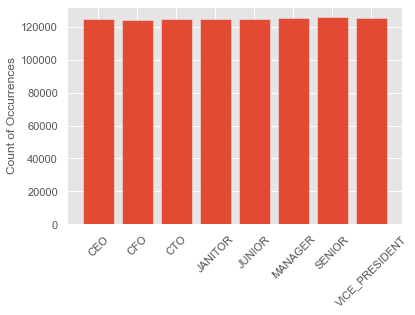



DEGREE Distribution:


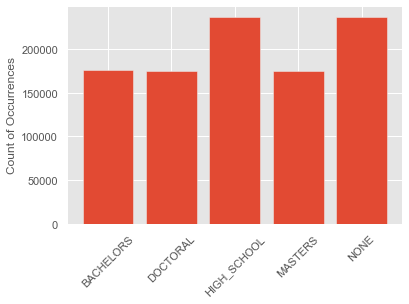



MAJOR Distribution:


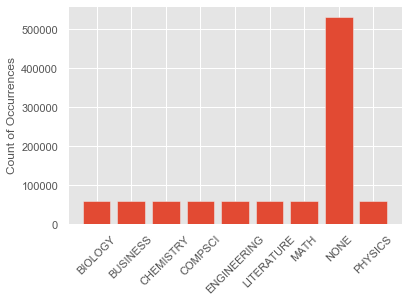



INDUSTRY Distribution:


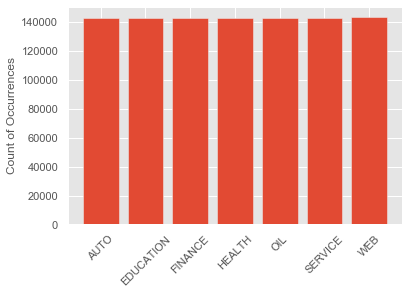

In [311]:
# All Categorical variable generally follows uniform distribution with exception of 'NONE' values
for i in df.columns:
    if i in ('jobType','degree','major', 'industry'):
        x = np.array(df[i].value_counts().sort_index().index)
        y = np.array(df[i].value_counts().sort_index())
        print(str.upper(i)+" Distribution:")
        plt.style.use('ggplot')
        plt.bar(x,y)
        plt.xticks(rotation=45)
        plt.ylabel('Count of Occurrences')
        plt.show()
        print("\n")

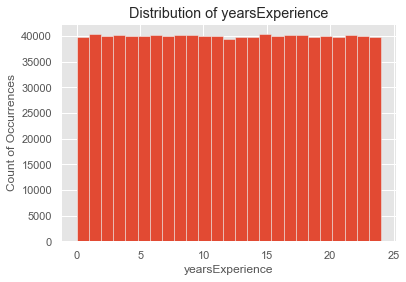

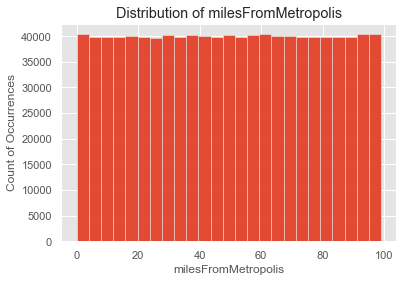

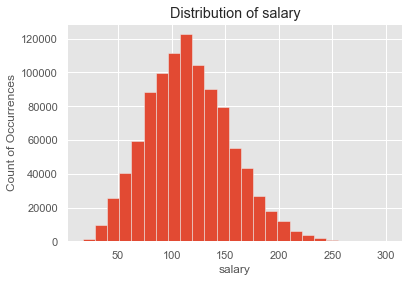

In [312]:
# All the Numerical variable generally follows uniform distribution exception salary which follows normal distribution with
# a slight right-skewed distribution
for i in df.columns:
    if i in ('yearsExperience','milesFromMetropolis','salary'):
        plt.style.use('ggplot')
        plt.hist(x=np.array(df[i]),bins=25)
        plt.title('Distribution of ' + str(i))
        plt.xlabel(str(i))
        plt.ylabel('Count of Occurrences')
        plt.show()

In [313]:
df.describe()

,yearsExperience,milesFromMetropolis,salary
count,1000000.000000,1000000.000000,1000000.000000
mean,11.992386,49.529260,116.062383
std,7.212391,28.877733,38.717084
min,0.000000,0.000000,17.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


In [314]:
df.describe(include='object')

,jobId,companyId,jobType,degree,major,industry
count,1000000,1000000,1000000,1000000,1000000,1000000
unique,1000000,63,8,5,9,7
top,JOB1362684638492,COMP39,SENIOR,HIGH_SCHOOL,NONE,WEB
freq,1,16193,125886,236976,532355,143206


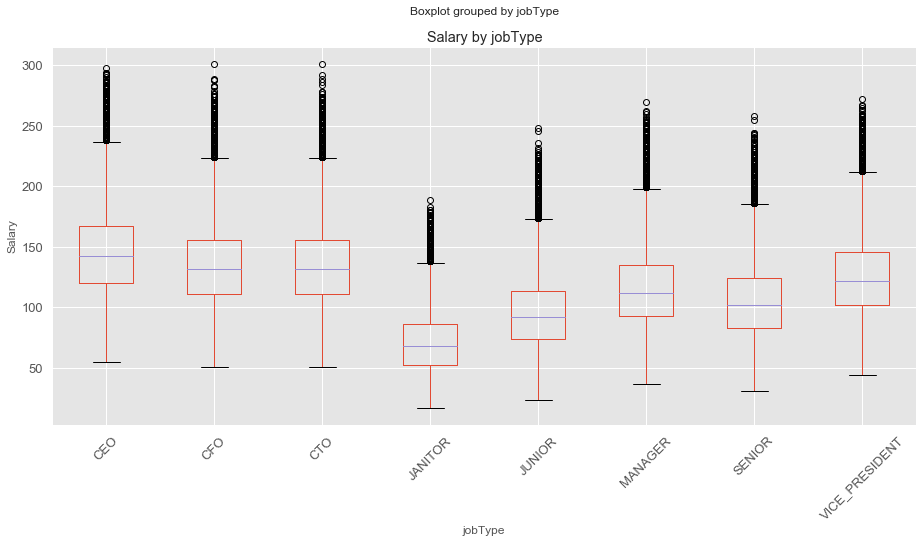

In [315]:
# correlation between jobType and salary
df.boxplot(column=['salary'], by=['jobType'], figsize=(15,7), fontsize=13, rot=45)
plt.title("Salary by jobType")
plt.xlabel("jobType")
plt.ylabel("Salary")
plt.show()

###### Ranking of salary wrt jobType is 
CEO,
CFO, CTO,
VICE_PRESIDENT,
MANAGER,
SENIOR,
JUNIOR,
JANITOR

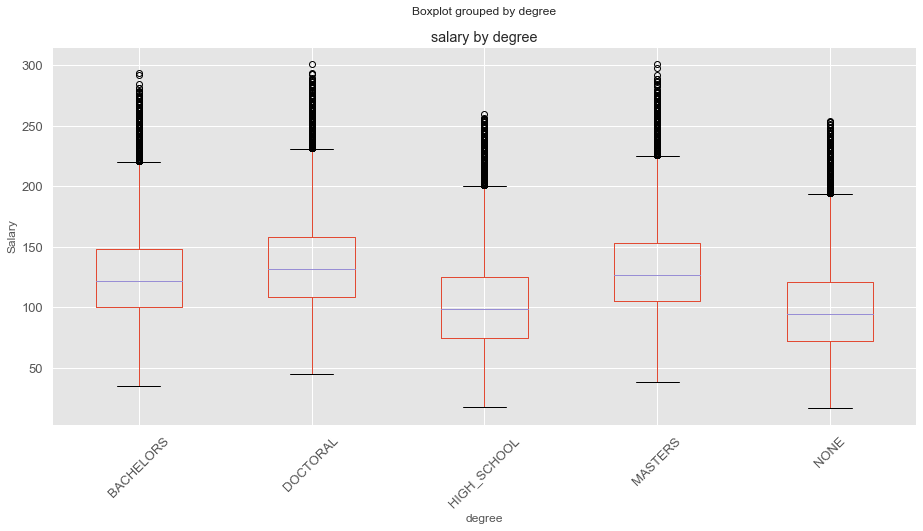

In [316]:
#correlation between degree and salary
df.boxplot(column=['salary'], by=['degree'], figsize=(15,7), fontsize=13, rot=45)
plt.title("salary by degree")
plt.xlabel("degree")
plt.ylabel("Salary")
plt.show()

###### Ranking of salary wrt degree is
DOCTORAL, 
MASTERS,
BACHELORS,
HIGH_SCHOOL,
NONE

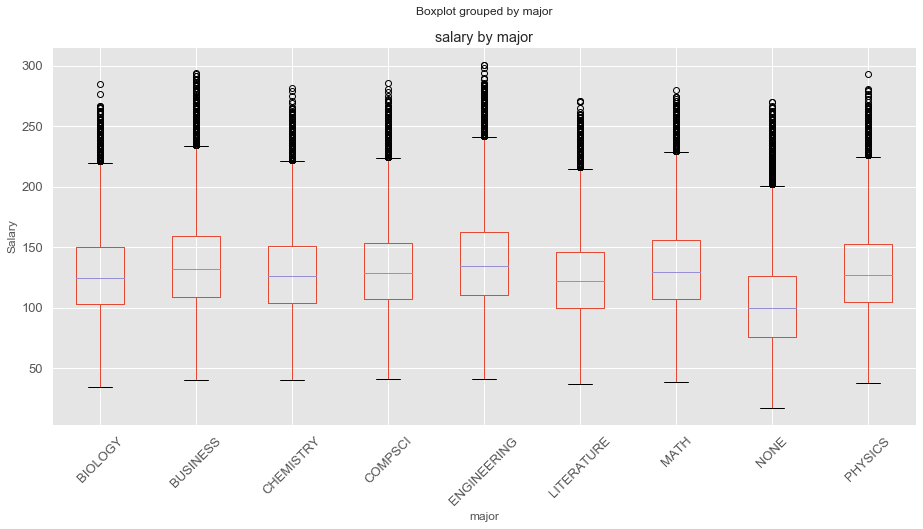

In [317]:
#correlation between major and salary
df.boxplot(column=['salary'], by=['major'], figsize=(15,7), fontsize=13, rot=45)
plt.title("salary by major")
plt.xlabel("major")
plt.ylabel("Salary")
plt.show()

###### Ranking of salary wrt major is
ENGINEERING,
BUSINESS,
MATH,
COMPSCI,
PHYSICS,
CHEMISTRY,
BIOLOGY,
LITERATURE,
NONE

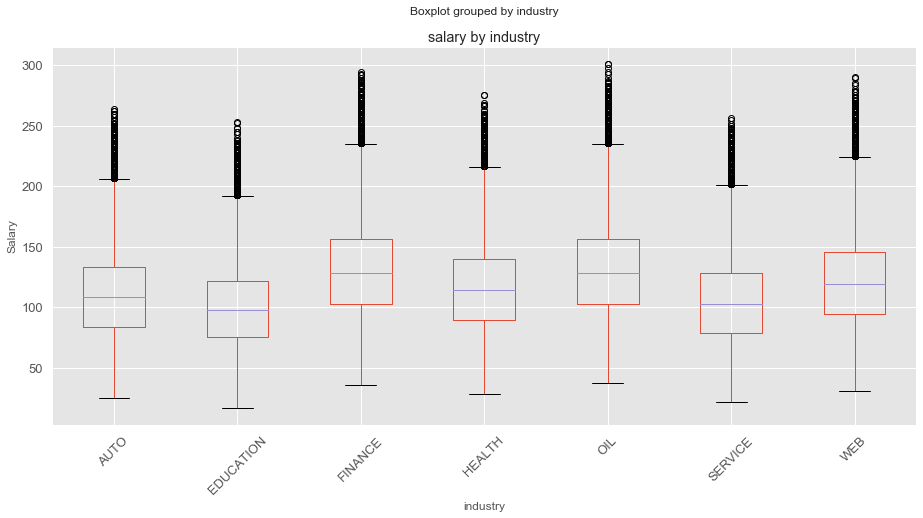

In [318]:
#correlation between industry and salary
df.boxplot(column=['salary'], by=['industry'], figsize=(15,7), fontsize=13, rot=45)
plt.title("salary by industry")
plt.xlabel("industry")
plt.ylabel("Salary")
plt.show()

###### Ranking of salary wrt industry is 
OIL,
FINANCE,
WEB,
HEALTH,
AUTO,
SERVICE,
EDUCATION

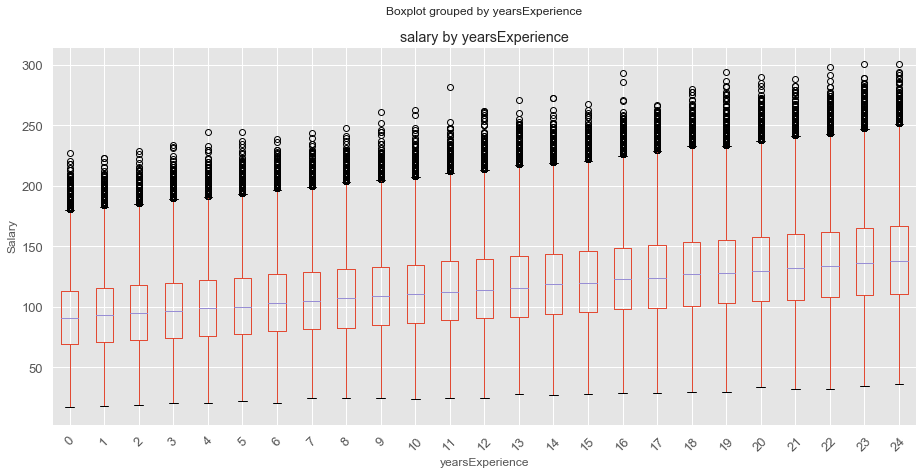

In [319]:
#correlation between yearsExperience and salary
df.boxplot(column=['salary'], by=['yearsExperience'], figsize=(15,7), fontsize=13, rot=45)
plt.title("salary by yearsExperience")
plt.xlabel("yearsExperience")
plt.ylabel("Salary")
plt.show()

###### The general trend of salary wrt yearsExperience - more the experience more is the salary

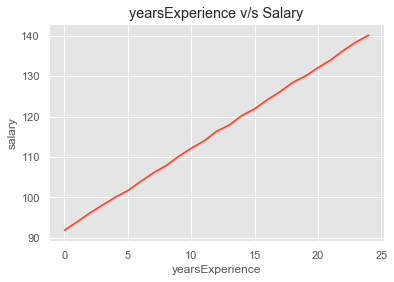

In [320]:
# As experience increases the salary also increases
sns.lineplot(x='yearsExperience', y='salary',data=df)
plt.title("yearsExperience v/s Salary")
plt.show()

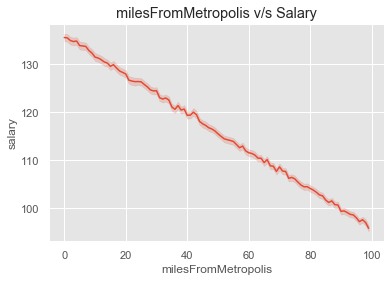

In [321]:
# Near to metropolis area, higher is the salary
sns.lineplot(x='milesFromMetropolis', y='salary',data=df)
plt.title("milesFromMetropolis v/s Salary")
plt.show()

##### Checking correlation between the variables (categorical & numerical with the target variable [salary])

In [322]:
# The correlation between companyId and salary is very weak
df_anova_companyId = df[['companyId','salary']]
group_companyId = df_anova_companyId.groupby(['companyId'])
anova_res_companyId = stats.f_oneway(group_companyId.get_group('COMP0')['salary'],group_companyId.get_group('COMP62')['salary'])
print(anova_res_companyId)

F_onewayResult(statistic=0.5224147179186824, pvalue=0.46981879385905223)


###### There is a very weak correlation between companyId and salary

In [323]:
# The correlation between jobType and salary is very strong
df_anova_jobType = df[['jobType','salary']]
group_jobType = df_anova_jobType.groupby(['jobType'])
anova_res_jobType = stats.f_oneway(group_jobType.get_group('VICE_PRESIDENT')['salary'],group_jobType.get_group('JUNIOR')['salary'])
print(anova_res_jobType)

F_onewayResult(statistic=60037.290068076254, pvalue=0.0)


###### There is a very strong correlation between jobType and salary

In [324]:
# The correlation between degree and salary is very strong
df_anova_degree = df[['degree','salary']]
group_degree = df_anova_degree.groupby(['degree'])
anova_res_degree = stats.f_oneway(group_degree.get_group('HIGH_SCHOOL')['salary'],group_degree.get_group('BACHELORS')['salary'])
print(anova_res_degree)

F_onewayResult(statistic=43908.70495187321, pvalue=0.0)


###### There is a very strong correlation between degree and salary

In [325]:
# The correlation between industry and salary is very strong
df_anova_industry = df[['industry','salary']]
group_industry = df_anova_industry.groupby(['industry'])
anova_res_industry = stats.f_oneway(group_industry.get_group('WEB')['salary'],group_industry.get_group('HEALTH')['salary'])
print(anova_res_industry)

F_onewayResult(statistic=1773.4775464138456, pvalue=0.0)


###### There is a very strong correlation between industry and salary

In [326]:
# The correlation between major and salary is very strong
df_anova_major = df[['major','salary']]
group_major = df_anova_major.groupby(['major'])
anova_res_major = stats.f_oneway(group_major.get_group('CHEMISTRY')['salary'],group_major.get_group('BUSINESS')['salary'])
print(anova_res_major)

F_onewayResult(statistic=983.2017903936412, pvalue=6.259621145849743e-215)


###### There is a very strong correlation between major and salary

In [327]:
# The correlation between yearsExperience and salary is very strong
df_anova_yearsExperience = df[['yearsExperience','salary']]
group_yearsExperience = df_anova_yearsExperience.groupby(['yearsExperience'])
anova_res_yearsExperience = stats.f_oneway(group_yearsExperience.get_group(1)['salary'],group_yearsExperience.get_group(24)['salary'])
print(anova_res_yearsExperience)

F_onewayResult(statistic=32079.3857365634, pvalue=0.0)


###### There is a very strong correlation between yearsExperience and salary

In [328]:
# The correlation between milesFromMetropolis and salary is very strong
df_anova_milesFromMetropolis = df[['milesFromMetropolis','salary']]
group_milesFromMetropolis = df_anova_milesFromMetropolis.groupby(['milesFromMetropolis'])
anova_res_milesFromMetropolis = stats.f_oneway(group_milesFromMetropolis.get_group(83)['salary'],group_milesFromMetropolis.get_group(1)['salary'])
print(anova_res_milesFromMetropolis)

F_onewayResult(statistic=3748.1663701469015, pvalue=0.0)


###### There is a very strong correlation between milesFromMetropolis and salary

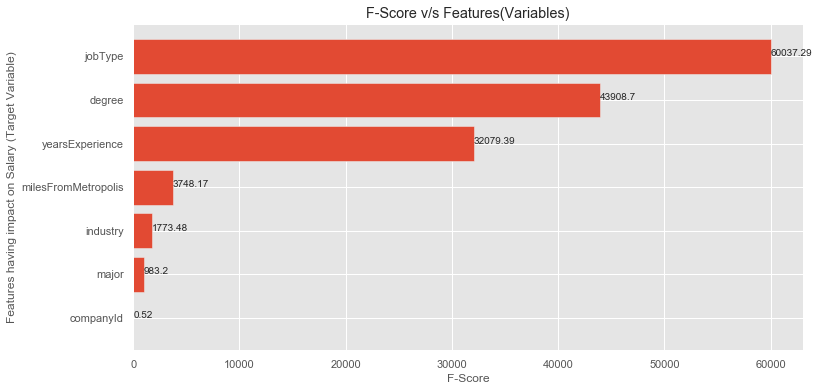

In [329]:
lst = {'companyId':anova_res_companyId[0],'jobType':anova_res_jobType[0],'degree':anova_res_degree[0],
       'industry':anova_res_industry[0],'major':anova_res_major[0],'yearsExperience':anova_res_yearsExperience[0],
       'milesFromMetropolis':anova_res_milesFromMetropolis[0]}
dic = {i:k for i,k in lst.items()}
dic = dict(sorted(dic.items(), key=lambda x:x[1]))
x=[]
y=[]
for k, v in dic.items():
    x.append(k)
    y.append(v)

plt.figure(figsize=(12,6))
plt.barh(x,y)
for index, value in enumerate(y):
    plt.text(value, index, str(round(value,2)))
plt.title('F-Score v/s Features(Variables)')
plt.xlabel('F-Score')
plt.ylabel('Features having impact on Salary (Target Variable)')
plt.show()

##### Above graph shows the impact on Target variable by the features variables --> jobType has the highest impact while companyId has the least impact on the salary variable

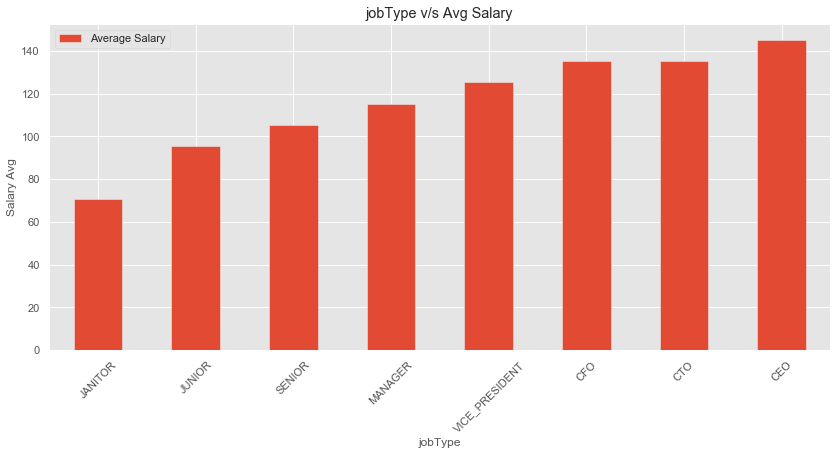

In [330]:
# Average salary heirarchy among the jobType
df_avg_sal = pd.DataFrame(df.groupby('jobType',as_index=False)['salary'].agg({'Average Salary':'mean'}))
df_avg_sal = df_avg_sal.sort_values('Average Salary')
df_avg_sal.plot.bar(x='jobType', figsize=(14,6), rot=45)
plt.ylabel('Salary Avg')
plt.title('jobType v/s Avg Salary')
plt.show()

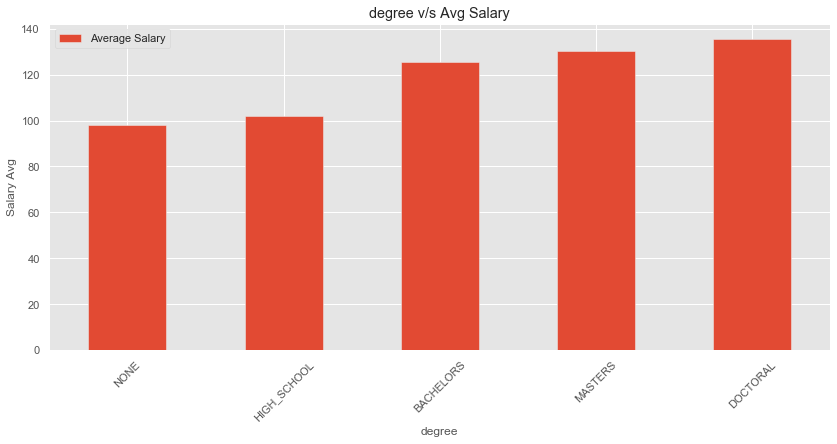

In [331]:
# Average salary heirarchy among the degree
df_avg_sal = pd.DataFrame(df.groupby('degree',as_index=False)['salary'].agg({'Average Salary':'mean'}))
df_avg_sal = df_avg_sal.sort_values('Average Salary')
df_avg_sal.plot.bar(x='degree', figsize=(14,6), rot=45)
plt.ylabel('Salary Avg')
plt.title('degree v/s Avg Salary')
plt.show()

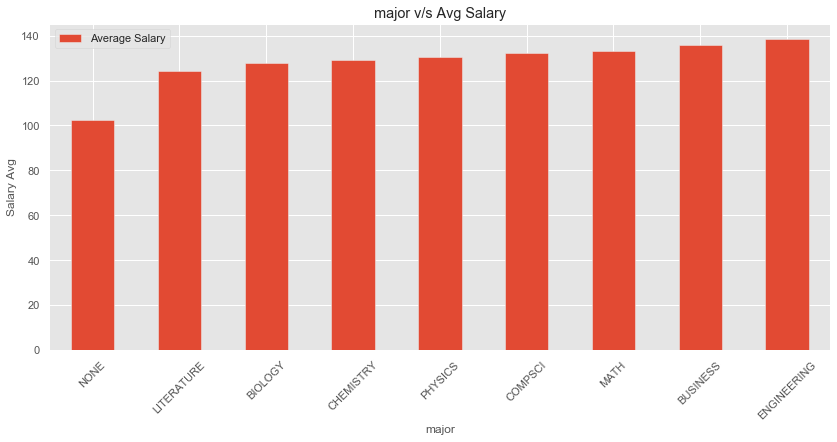

In [332]:
# Average salary heirarchy among the major
df_avg_sal = pd.DataFrame(df.groupby('major',as_index=False)['salary'].agg({'Average Salary':'mean'}))
df_avg_sal = df_avg_sal.sort_values('Average Salary')
df_avg_sal.plot.bar(x='major', figsize=(14,6), rot=45)
plt.ylabel('Salary Avg')
plt.title('major v/s Avg Salary')
plt.show()

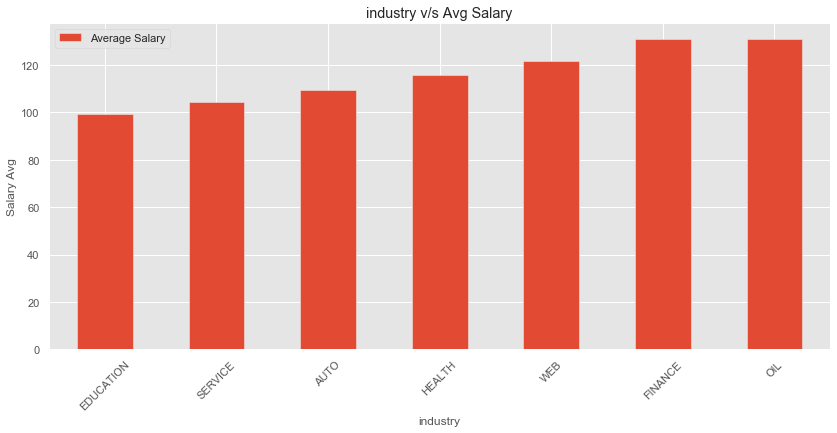

In [333]:
# Average salary heirarchy among the industry
df_avg_sal = pd.DataFrame(df.groupby('industry',as_index=False)['salary'].agg({'Average Salary':'mean'}))
df_avg_sal = df_avg_sal.sort_values('Average Salary')
df_avg_sal.plot.bar(x='industry', figsize=(14,6), rot=45)
plt.ylabel('Salary Avg')
plt.title('industry v/s Avg Salary')
plt.show()

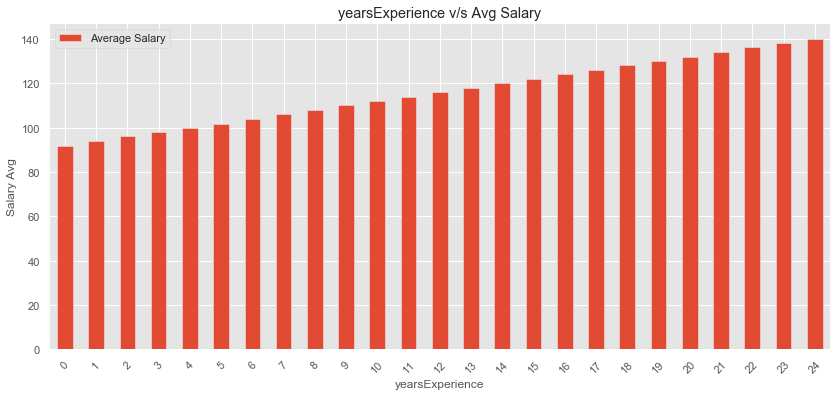

In [334]:
# Average salary heirarchy among the yearsExperience
df_avg_sal = pd.DataFrame(df.groupby('yearsExperience',as_index=False)['salary'].agg({'Average Salary':'mean'}))
df_avg_sal = df_avg_sal.sort_values('Average Salary')
df_avg_sal.plot.bar(x='yearsExperience', figsize=(14,6), rot=45)
plt.ylabel('Salary Avg')
plt.title('yearsExperience v/s Avg Salary')
plt.show()

##### Feature selection/impact analysis using Lasso Regression 

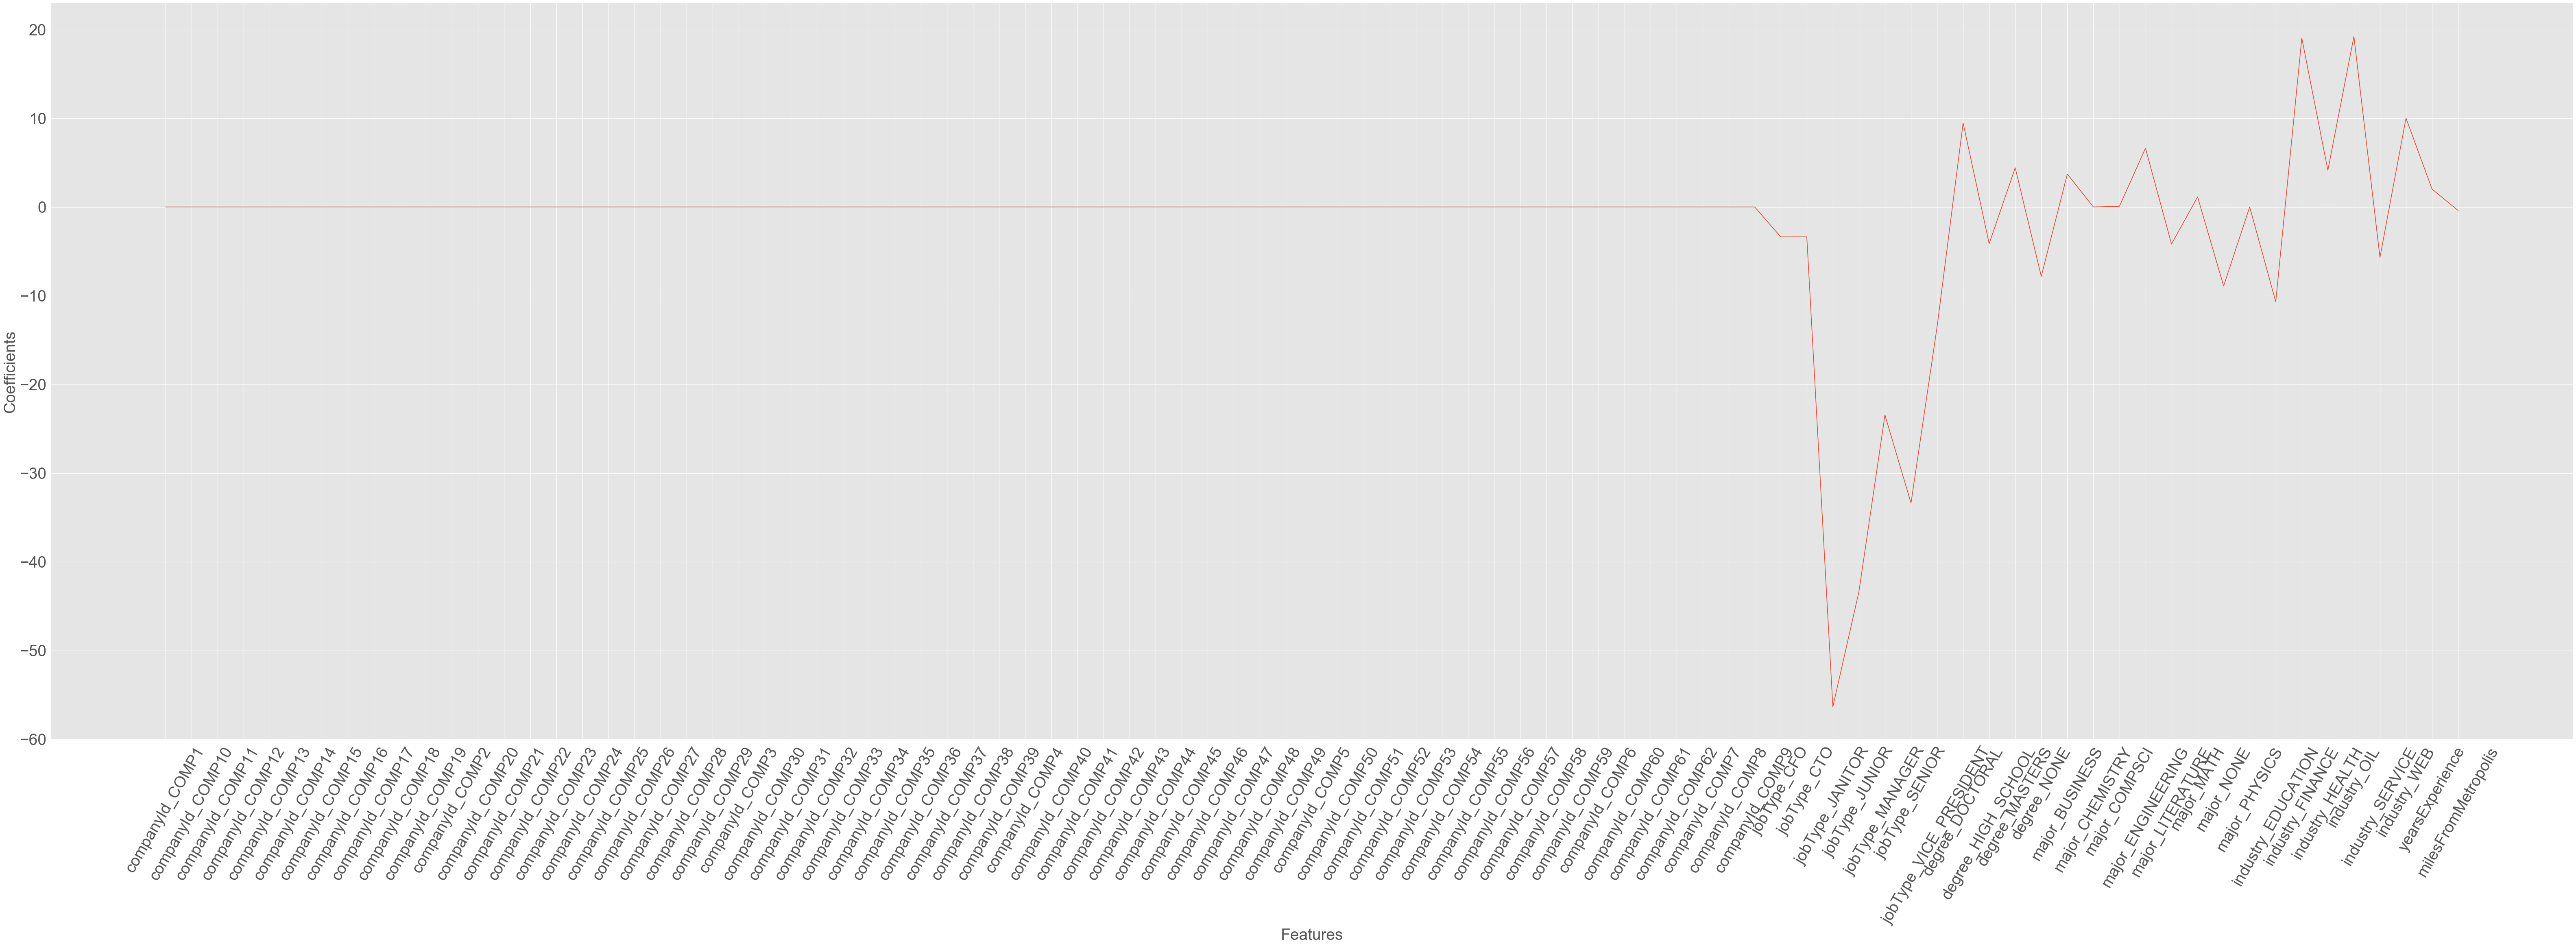

In [335]:
df_copy = df
df_trail = pd.get_dummies(df_copy[df_copy.columns[1:6]], drop_first=True)
df_copy = df_copy.drop(df_copy.columns[1:6], axis=1)
df2 = pd.concat([df_trail,df_copy], axis=1)
df2 = df2.drop(columns='jobId',axis=1)

lasso = Lasso(alpha=0.1)
lasso_coef = lasso.fit(np.array(df2.iloc[:,0:89]), np.array(df2.iloc[:,89:90])).coef_

names = [x for x in df2.columns if x != 'salary']
plt.figure(figsize=(100, 30), dpi=80)

_=plt.plot(range(len(names)),lasso_coef)
_=plt.xlabel('Features',fontsize=35)
_=plt.xticks(range(len(names)),names,rotation=60,fontsize=35)
_=plt.ylabel('Coefficients',fontsize=35)
_=plt.yticks(fontsize=35)
plt.show()

###### The above graph shows which feature/variables has what amount of impact on the target variable
From the above graph we can conclude that 'companyId' has the very least impact on the target variable as it has Coefficient value of 0 for all companyId except for companyId = 'COMP9', and remaining features has a significant impact on our target variable and hence we retain them for our model

In [336]:
# Label encoding for the categorical features
data_encoded = df.copy(deep = True) 
le = LabelEncoder()
category_columns = [i for i in df.columns if df[i].dtypes == 'O']

for i in category_columns:
    data_encoded[i] = le.fit_transform(data_encoded[i])
data_encoded.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,0,31,1,3,6,3,10,83,130.0
1,1,11,0,2,7,6,3,73,101.0
2,2,48,7,1,8,3,10,38,137.0
3,3,32,5,1,2,0,8,17,142.0
4,4,60,7,0,8,2,8,16,163.0


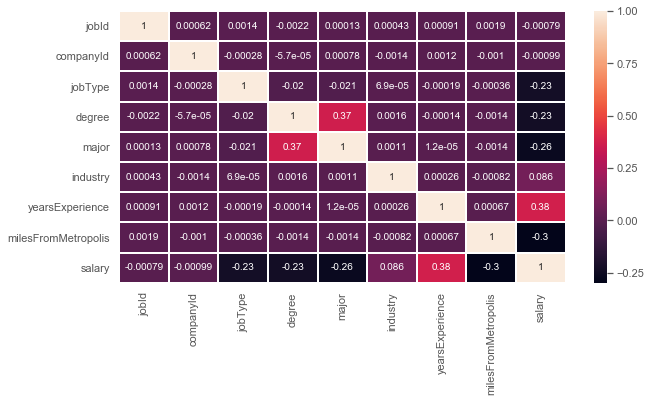

In [337]:
plt.rcParams['figure.figsize'] = (10.0, 5.0)
sns.heatmap(data_encoded.corr(), annot=True, linewidths=1)
plt.show()

In [338]:
data_encoded.corr()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
jobId,1.000000,0.000617,0.001394,-0.002249,0.000132,0.000429,0.000913,0.001896,-0.000789
companyId,0.000617,1.000000,-0.000284,-0.000057,0.000780,-0.001446,0.001185,-0.001020,-0.000993
jobType,0.001394,-0.000284,1.000000,-0.020084,-0.020774,0.000069,-0.000186,-0.000365,-0.228672
degree,-0.002249,-0.000057,-0.020084,1.000000,0.370089,0.001551,-0.000144,-0.001359,-0.231794
major,0.000132,0.000780,-0.020774,0.370089,1.000000,0.001075,0.000012,-0.001369,-0.262435
industry,0.000429,-0.001446,0.000069,0.001551,0.001075,1.000000,0.000263,-0.000819,0.086500
yearsExperience,0.000913,0.001185,-0.000186,-0.000144,0.000012,0.000263,1.000000,0.000673,0.375012
milesFromMetropolis,0.001896,-0.001020,-0.000365,-0.001359,-0.001369,-0.000819,0.000673,1.000000,-0.297684
salary,-0.000789,-0.000993,-0.228672,-0.231794,-0.262435,0.086500,0.375012,-0.297684,1.000000


### ---- 5 Establish a baseline ----

In [339]:
mean_squared_error_lst = {}
cols = ['jobType','degree','major','industry','yearsExperience','milesFromMetropolis']

for i in cols:
    df_b = pd.DataFrame(df['salary'].groupby(df[i]).mean())
    df_avg = pd.merge(df,df_b,on=i,how='inner')
    mean_squared_error_lst[i] = mean_squared_error(df_avg['salary_x'],df_avg['salary_y'])
    
for i,j in mean_squared_error_lst.items():
    print("The mean_squared_error based on the " + str(i) + " = " + str(j))

The mean_squared_error based on the jobType = 963.920480754804
The mean_squared_error based on the degree = 1257.6100968884768
The mean_squared_error based on the major = 1284.0631928100468
The mean_squared_error based on the industry = 1367.1185290148921
The mean_squared_error based on the yearsExperience = 1288.1736878350932
The mean_squared_error based on the milesFromMetropolis = 1366.0413347426845


### ---- 6 Hypothesize solution ----

###### From the above steps - we can conclude that jobId and companyId doesn't have significant impact on salary and we can retain all the other feature variables with scaling of numerical features for our model creation

I will be implementing 3 models - Linear Regression, Random Forest, and Gradient Boosting Tree

## Part 3 - DEVELOP

### ---- 7 Engineer features  ----

In [341]:
df_dummies = df.copy(deep=True)
df_dummies.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130.0
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101.0
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137.0
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142.0
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163.0


In [342]:
df_dummies = pd.get_dummies(df_dummies, columns=['jobType'], drop_first=True)
df_dummies = pd.get_dummies(df_dummies, columns=['degree'], drop_first=True)
df_dummies = pd.get_dummies(df_dummies, columns=['major'], drop_first=True)
df_dummies = pd.get_dummies(df_dummies, columns=['industry'], drop_first=True)
df_dummies.head()

,jobId,companyId,yearsExperience,milesFromMetropolis,salary,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,...,major_LITERATURE,major_MATH,major_NONE,major_PHYSICS,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,JOB1362684407687,COMP37,10,83,130.0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,JOB1362684407688,COMP19,3,73,101.0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,JOB1362684407689,COMP52,10,38,137.0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,JOB1362684407690,COMP38,8,17,142.0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,JOB1362684407691,COMP7,8,16,163.0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0


In [343]:
# Normalizing the data using MinMax scaling method
scaler = MinMaxScaler()
# transform data
df_dummies[['yearsExperience', 'milesFromMetropolis']] = scaler.fit_transform(df_dummies[['yearsExperience', 'milesFromMetropolis']])
df_dummies.head()

,jobId,companyId,yearsExperience,milesFromMetropolis,salary,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,...,major_LITERATURE,major_MATH,major_NONE,major_PHYSICS,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,JOB1362684407687,COMP37,0.416667,0.838384,130.0,1,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,JOB1362684407688,COMP19,0.125000,0.737374,101.0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,JOB1362684407689,COMP52,0.416667,0.383838,137.0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,JOB1362684407690,COMP38,0.333333,0.171717,142.0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,JOB1362684407691,COMP7,0.333333,0.161616,163.0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0


### ---- 8 Create models ----

In [344]:
cat_cols = df[['jobType', 'degree', 'major', 'industry']]
num_cols = df[['yearsExperience', 'milesFromMetropolis']]
y = df[['salary']]

cat_dummies = pd.get_dummies(cat_cols, drop_first=True)
X = pd.concat([cat_dummies,num_cols],axis=1)

X[['yearsExperience','milesFromMetropolis']] = scaler.fit_transform(X[['yearsExperience', 'milesFromMetropolis']])


X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=21)

In [345]:
#Linear Regression Model analysis

reg = LinearRegression()

reg.fit(X_train,y_train)
reg.score(X_train,y_train)

y_reg_pred = reg.predict(X_test)

reg_mse = mean_squared_error(y_test,y_reg_pred)
reg_r2 = r2_score(y_test,y_reg_pred)
print("The mean_squared_error (MSE) on test data is : {:f}".format(reg_mse))
print("The r2 sqaured error on test data is : {:f}".format(reg_r2))

The mean_squared_error (MSE) on test data is : 385.492879
The r2 sqaured error on test data is : 0.743961


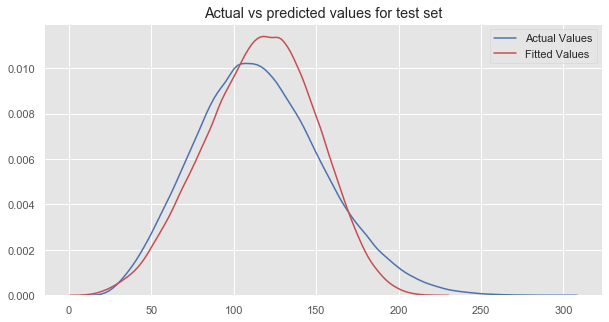

In [346]:
#Linear Regression Model evaluation using visualisation
sns.distplot(y_test, color='b',hist=False,label="Actual Values")
sns.distplot(y_reg_pred, color='r',hist=False,label="Fitted Values")
plt.title('Actual vs predicted values for test set')
plt.show()

In [347]:
#Random Forest Regression Model analysis

random_forest = RandomForestRegressor(n_estimators=200,min_samples_leaf=50,n_jobs=2,max_depth=40,max_features="auto",min_samples_split = 50,oob_score=True,verbose=0,random_state=100)

random_forest.fit(X_train,y_train)
random_forest.score(X_train,y_train)

y_random_forest_pred = random_forest.predict(X_test)

random_forest_mse = mean_squared_error(y_test, y_random_forest_pred)
random_forest_r2 = r2_score(y_test,y_random_forest_pred)

print("The mean_squared_error (MSE) on test data is : {:f}".format(random_forest_mse))
print("The r2 sqaured error on test data is : {:f}".format(random_forest_r2))

The mean_squared_error (MSE) on test data is : 375.533523
The r2 sqaured error on test data is : 0.750576


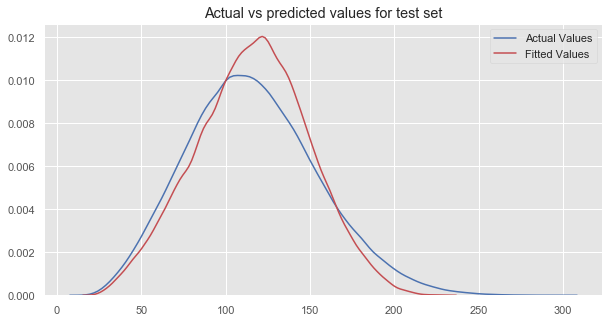

In [348]:
#Random Forest Regression Model evaluation using visualisation
sns.distplot(y_test, color='b',hist=False,label="Actual Values")
sns.distplot(y_random_forest_pred, color='r',hist=False,label="Fitted Values")
plt.title('Actual vs predicted values for test set')
plt.show()

In [349]:
#Gradient Boosting Model analysis

gradientboostingreg = GradientBoostingRegressor(n_estimators= 160, max_depth= 6, loss='ls', verbose=0, random_state=100)


gradientboostingreg.fit(X_train,y_train)
gradientboostingreg.score(X_train,y_train)

y_gradientboostingreg_pred = gbr.predict(X_test)

gradientboosting_mse = mean_squared_error(y_test, y_gradientboostingreg_pred)
gradientboosting_r2 = r2_score(y_test,y_p_gbr)

print("The mean_squared_error (MSE) on test data is : {:f}".format(gradientboosting_mse))
print("The r2 sqaured error on test data is : {:f}".format(gradientboosting_r2))

The mean_squared_error (MSE) on test data is : 359.130371
The r2 sqaured error on test data is : 0.761471


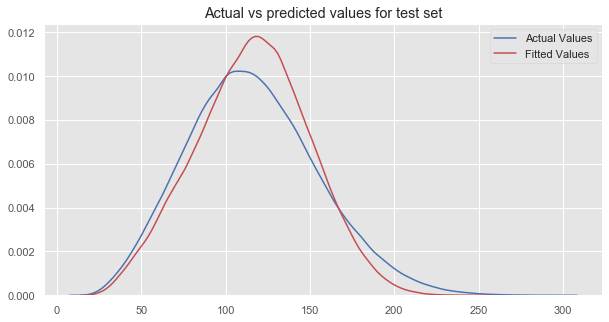

In [350]:
#Gradient Boosting Model evaluation using visualisation
sns.distplot(y_test, color='b',hist=False,label="Actual Values")
sns.distplot(y_gradientboostingreg_pred, color='r',hist=False,label="Fitted Values")
plt.title('Actual vs predicted values for test set')
plt.show()

### ---- 9 Test models ----

In [351]:
cv_results_reg = cross_val_score(reg,X_test,y_test,cv=5)
np.mean(cv_results_reg)

data_res_reg = {'Model':'Linear Regression','MSE':[reg_mse],'R_Sqaured (Avg of 5 fold split)':[np.mean(cv_results_reg)]}
results_reg = pd.DataFrame(data_res_reg,columns=['Model','MSE','R_Sqaured (Avg of 5 fold split)'])
results_reg

,Model,MSE,R_Sqaured (Avg of 5 fold split)
0,Linear Regression,385.492879,0.743909


In [352]:
cv_results_random_forest = cross_val_score(random_forest,X_test,y_test,cv=5)
np.mean(cv_results_random_forest)

data_res_random_forest = {'Model':'Random Forest Regression','MSE':[random_forest_mse],'R_Sqaured (Avg of 5 fold split)':[np.mean(cv_results_random_forest)]}
results_random_forest = pd.DataFrame(data_res_random_forest,columns=['Model','MSE','R_Sqaured (Avg of 5 fold split)'])
results_random_forest

,Model,MSE,R_Sqaured (Avg of 5 fold split)
0,Random Forest Regression,375.533523,0.737052


In [353]:
cv_results_gradientboostingreg = cross_val_score(reg,X_test,y_test,cv=5)
np.mean(cv_results_gradientboostingreg)

data_res_gradientboostingreg = {'Model':'Gradient Boosting Regression','MSE':[gradientboosting_mse],'R_Sqaured (Avg of 5 fold split)':[np.mean(cv_results_gradientboostingreg)]}
results_gradientboostingreg = pd.DataFrame(data_res_gradientboostingreg,columns=['Model','MSE','R_Sqaured (Avg of 5 fold split)'])
results_gradientboostingreg

,Model,MSE,R_Sqaured (Avg of 5 fold split)
0,Gradient Boosting Regression,359.130371,0.743909


In [354]:
result = pd.concat([results_reg,results_random_forest,results_gradientboostingreg], axis=0, ignore_index=True)
result

,Model,MSE,R_Sqaured (Avg of 5 fold split)
0,Linear Regression,385.492879,0.743909
1,Random Forest Regression,375.533523,0.737052
2,Gradient Boosting Regression,359.130371,0.743909


### ---- 10 Select best model  ----

###### Gradient Boosting Regression is the best model, since it fetched the lowest MSE i.e (MSE < 360) which was our goal to select the best model and an average of r_sqaured for 5 fold split of 74.40%

## Part 4 - DEPLOY

### ---- 11 Automate pipeline ----

In [369]:
#We had already read the test_data in the earlier step
test_f.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


In [370]:
#Understanding the test_data
test_f.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
jobId                  1000000 non-null object
companyId              1000000 non-null object
jobType                1000000 non-null object
degree                 1000000 non-null object
major                  1000000 non-null object
industry               1000000 non-null object
yearsExperience        1000000 non-null int64
milesFromMetropolis    1000000 non-null int64
dtypes: int64(2), object(6)
memory usage: 61.0+ MB


In [388]:
#getting dummies for the categorical features
test_data = test_f.copy(deep=True)

test_data = pd.get_dummies(test_data, columns=['jobType'], drop_first=True)
test_data = pd.get_dummies(test_data, columns=['degree'], drop_first=True)
test_data = pd.get_dummies(test_data, columns=['major'], drop_first=True)
test_data = pd.get_dummies(test_data, columns=['industry'], drop_first=True)

test_data[['yearsExperience','milesFromMetropolis']] = scaler.fit_transform(test_data[['yearsExperience','milesFromMetropolis']])

test_data.head()

,jobId,companyId,yearsExperience,milesFromMetropolis,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,...,major_LITERATURE,major_MATH,major_NONE,major_PHYSICS,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,JOB1362685407687,COMP33,0.916667,0.737374,0,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
1,JOB1362685407688,COMP13,0.833333,0.474747,0,0,0,1,0,0,...,0,0,1,0,0,0,0,0,0,0
2,JOB1362685407689,COMP10,0.708333,0.090909,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,JOB1362685407690,COMP21,0.583333,0.969697,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
4,JOB1362685407691,COMP36,0.416667,0.444444,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0


In [389]:
#preparing the data for the model input
X_test_f = test_data.iloc[:,2:]
X_test_f.columns

Index(['yearsExperience', 'milesFromMetropolis', 'jobType_CFO', 'jobType_CTO',
       'jobType_JANITOR', 'jobType_JUNIOR', 'jobType_MANAGER',
       'jobType_SENIOR', 'jobType_VICE_PRESIDENT', 'degree_DOCTORAL',
       'degree_HIGH_SCHOOL', 'degree_MASTERS', 'degree_NONE', 'major_BUSINESS',
       'major_CHEMISTRY', 'major_COMPSCI', 'major_ENGINEERING',
       'major_LITERATURE', 'major_MATH', 'major_NONE', 'major_PHYSICS',
       'industry_EDUCATION', 'industry_FINANCE', 'industry_HEALTH',
       'industry_OIL', 'industry_SERVICE', 'industry_WEB'],
      dtype='object')

In [390]:
#feeding the data into model and fetching the results
y_final_pred = gbr.predict(X_test_f)

In [393]:
y_final = pd.DataFrame(y_final_pred)

predicted_df = pd.concat([test_data['jobId'], y_final], axis=1)
predicted_df = predicted_df.rename(columns={0:'salary'})

predicted_df.head()

,jobId,salary
0,JOB1362685407687,87.338567
1,JOB1362685407688,66.662549
2,JOB1362685407689,79.338373
3,JOB1362685407690,99.907032
4,JOB1362685407691,98.841554


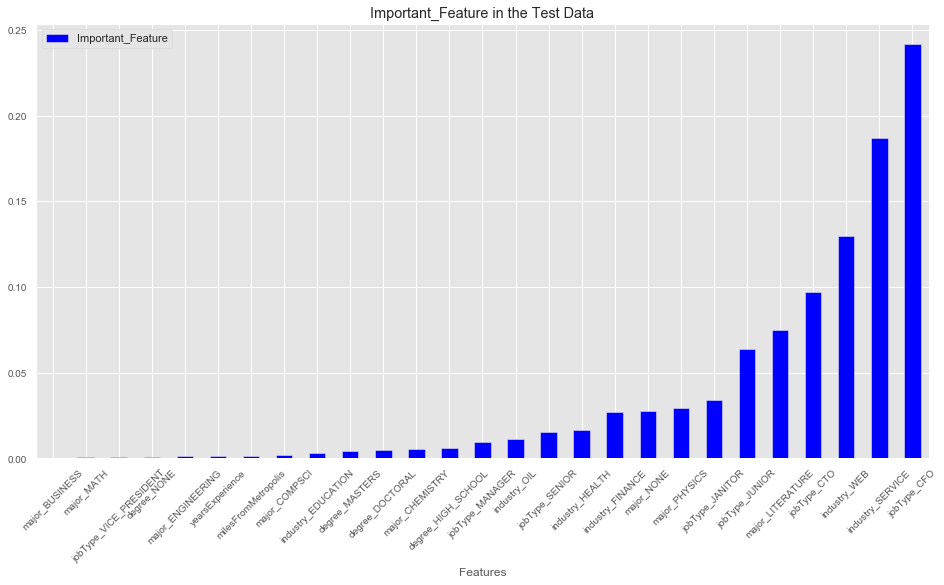

In [401]:
# Get importance from the selected Model
important_feature = gbr.feature_importances_

# Plot feature importance
important_features = pd.DataFrame({'Feature':X_test_f.columns, "Important_Feature" : important_feature})
important_features.sort_values(by='Important_Feature',inplace=True)
ax=important_features.plot.bar(x='Feature',rot=45, fontsize=10,color=['blue'],figsize=(16,8))
ax.set_title("Important_Feature in the Test Data")
ax.set_xlabel("Features")
plt.show()

###### Feature Importance - The above graph shows which feature variables had what amount of impact on the target variable



### ---- 12 Deploy solution ----

In [400]:
#saving the prediction to a csv file
predicted_df.to_csv("C:\\Users\\stnav\\DSDJ files\\Portfolio Projects\\test_salaries.csv", index=False)